# 딥러닝분석_(1)LSTM주가분석

In [ ]:
# 주가 데이터를 다운로드 받기 위해서 야후 파이낸스 라이브러리 설치
!pip install yfinance

# 1. 데이터 수집

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

### - 기업 주가 데이터를 다운로드하여 데이터프레임으로 저장

In [ ]:
name = 'GOOG'  #종목명 -구글

start_day = '2021-01-01'
end_day = '2024-08-01'

In [ ]:
stock = yf.download(name, start=start_day, end=end_day)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
print(stock.shape)  #작업 확인용 출력
stock.head() #작업 확인용 출력

(899, 5)


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2021-01-04,86.004646,87.617506,84.989952,87.462736,38038000
2021-01-05,86.635658,86.971569,85.495809,85.843413,22906000
2021-01-06,86.355476,86.987979,84.549524,84.730171,52042000
2021-01-07,88.941231,88.998455,86.443061,86.592849,45300000
2021-01-08,89.934532,90.065413,88.258723,88.977570,41012000


# 2. 데이터 준비 및 탐색

### - 분석할 컬럼(날짜, 종가) 추출

In [ ]:
stock2 = pd.DataFrame(stock['Close'])

stock2.head() #작업 확인용 출력

Ticker,GOOG
Date,
2021-01-04,86.004646
2021-01-05,86.635658
2021-01-06,86.355476
2021-01-07,88.941231
2021-01-08,89.934532


#### - 파일 저장

In [ ]:
# 다운로드한 주가 데이터를 파일 저장
stock2.to_csv('./'+name+'.csv')

### - 데이터 정규화

In [ ]:
stock2.reset_index()
stock_values = stock2.values

print(stock_values[0]) #작업 확인용 출력

[86.0046463]


In [ ]:
stock_values

### - 0~1 범위로 스케일링

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
stock_values_scaled=scaler.fit_transform(stock_values)

stock_values_scaled[0] #작업 확인용 출력

array([0.02671203])

# 3. 분석 모델 구축

## 3-1. 주가 분석 모델의 학습용 데이터 준비

In [ ]:
n_train = int(len(stock_values)*0.8)  #학습용 데이터 갯수
n_test = len(stock_values) - n_train  #평가용 데이터 갯수

print(n_train, n_test) #작업 확인용 출력

719 180


In [ ]:
X_train,Y_train=[],[]

#20일 구간의 주가를 x 값으로하고, 그 다음날 값을 y 값으로 정리하기
for i in range(20, n_train):
  X_train.append(stock_values_scaled[i-20:i,0])
  Y_train.append(stock_values_scaled[i,0])

X_train[0] #작업 확인용 출력

array([0.02671203, 0.03250785, 0.02993439, 0.05368445, 0.06280789,
       0.04430047, 0.03508124, 0.03866933, 0.03216959, 0.03034587,
       0.05533445, 0.0992329 , 0.10122109, 0.10570054, 0.10494639,
       0.11310075, 0.07358582, 0.08835883, 0.07584842, 0.10583761])

In [ ]:
Y_train[0] #작업 확인용 출력

np.float64(0.1177950505095311)

### - LSTM 모델의 입력층의 구조로 변형_reshape()

In [ ]:
X_train1, Y_train1 = np.array(X_train), np.array(Y_train)
X_train2 = np.reshape(X_train1, (X_train1.shape[0],X_train1.shape[1],1))

print(X_train2.shape) #작업 확인용 출력
X_train2[0] #작업 확인용 출력

(699, 20, 1)


array([[0.02671203],
       [0.03250785],
       [0.02993439],
       [0.05368445],
       [0.06280789],
       [0.04430047],
       [0.03508124],
       [0.03866933],
       [0.03216959],
       [0.03034587],
       [0.05533445],
       [0.0992329 ],
       [0.10122109],
       [0.10570054],
       [0.10494639],
       [0.11310075],
       [0.07358582],
       [0.08835883],
       [0.07584842],
       [0.10583761]])

## 3-2. LSTM 모델 구축

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

### - LSTM 모델 구성

In [ ]:
lstm_stock = Sequential()

lstm_stock.add(LSTM(units=20, return_sequences=True, input_shape=(X_train2.shape[1],1)))
lstm_stock.add(LSTM(units=20, return_sequences=False))
lstm_stock.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### - LSTM 모델 학습

In [ ]:
#학습 파라미터  설정
lstm_stock.compile(loss='mean_squared_error', optimizer='adam')

#학습 수행
lstm_stock.fit(X_train2, Y_train1, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
699/699 - 6s - 9ms/step - loss: 0.0051
Epoch 2/10
699/699 - 3s - 5ms/step - loss: 0.0019
Epoch 3/10
699/699 - 4s - 5ms/step - loss: 0.0014
Epoch 4/10
699/699 - 4s - 5ms/step - loss: 0.0011
Epoch 5/10
699/699 - 5s - 7ms/step - loss: 0.0010
Epoch 6/10
699/699 - 5s - 7ms/step - loss: 8.2713e-04
Epoch 7/10
699/699 - 5s - 7ms/step - loss: 7.1630e-04
Epoch 8/10
699/699 - 3s - 5ms/step - loss: 6.8331e-04
Epoch 9/10
699/699 - 6s - 8ms/step - loss: 6.8316e-04
Epoch 10/10
699/699 - 3s - 5ms/step - loss: 6.1991e-04


## 3-3. 평가 데이터로 주가 예측

### - 평가용 데이터 만들기

In [ ]:
stock_test = stock_values_scaled[n_train-20:]
X_test = []

for i in range(20, len(stock_test)):
  X_test.append(stock_test[i-20:i,0])


X_test[0] #작업 확인용 출력

array([0.5036144 , 0.52107503, 0.52564579, 0.51001358, 0.50727109,
       0.4867937 , 0.49739798, 0.51769261, 0.39473712, 0.36520959,
       0.36484393, 0.38632677, 0.38221311, 0.40296464, 0.41219775,
       0.4285612 , 0.43843431, 0.44711879, 0.45498073, 0.44062838])

### - LSTM 모델의 입력층의 구조로 변형_reshape()

In [ ]:
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

print(X_test.shape)  #작업 확인용 출력
print(X_test[0])

(180, 20, 1)
[[0.5036144 ]
 [0.52107503]
 [0.52564579]
 [0.51001358]
 [0.50727109]
 [0.4867937 ]
 [0.49739798]
 [0.51769261]
 [0.39473712]
 [0.36520959]
 [0.36484393]
 [0.38632677]
 [0.38221311]
 [0.40296464]
 [0.41219775]
 [0.4285612 ]
 [0.43843431]
 [0.44711879]
 [0.45498073]
 [0.44062838]]


### - 모델 예측 수행

In [ ]:
predicted_value = lstm_stock.predict(X_test)

predicted_value[0] #작업 확인용 출력

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


array([0.4439942], dtype=float32)

# 4. 결과 분석 및 시각화

##### - 예측값을 스케일링 이전 값(원래 주가)으로 되돌림.

In [ ]:
predicted_value = scaler.inverse_transform(predicted_value)

predicted_value[0] #작업 확인용 출력

array([131.43565], dtype=float32)

### - 그래프에 사용할 데이터 리스트 정리하기

In [ ]:
stock_train_vis = stock[:n_train]
stock_test_vis = stock[n_train:]
stock_test_vis['Predictions'] = predicted_value

<ipython-input-24-181e750172c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_test_vis['Predictions'] = predicted_value


In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'GOOG (2021-01-01 ~ 2024-08-01 )')

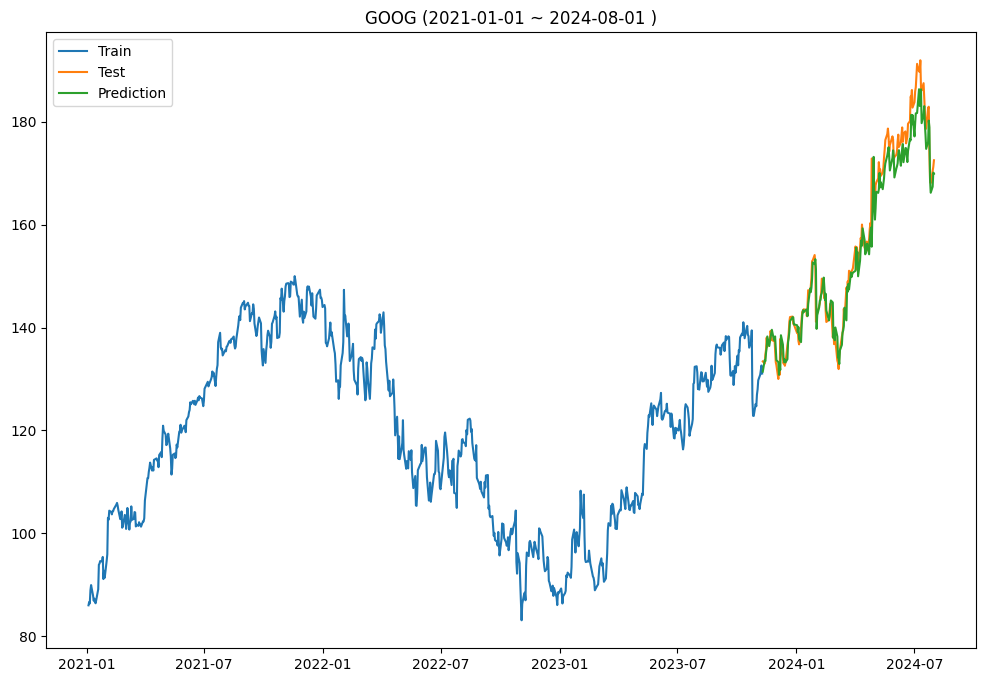

In [ ]:
plt.figure(figsize = (12,8))
plt.plot(stock_train_vis['Close'], label = 'Train')
plt.plot(stock_test_vis['Close'], label = 'Test')
plt.plot(stock_test_vis['Predictions'], label = 'Prediction')
plt.legend()
plt.title(name + ' (' + start_day + ' ~ ' + end_day + ' )')